In [1]:
# import os
# os.environ['LD_PRELOAD'] = '/usr/lib/aarch64-linux-gnu/libgomp.so.1'
# os.environ['OMP_NUM_THREADS'] = '1'

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Try to preview the images

color_image = cv.imread('../data/small_box/color_image.png')
depth_image = cv.imread('../data/small_box/raw_depth.png')
depth_display = cv.normalize(depth_image, None, 0, 255, cv.NORM_MINMAX)
depth_display = depth_display.astype(np.uint8)
print("depth: ", depth_image.shape)
print("RGB", color_image.shape)

depth:  (480, 640, 3)
RGB (480, 640, 3)


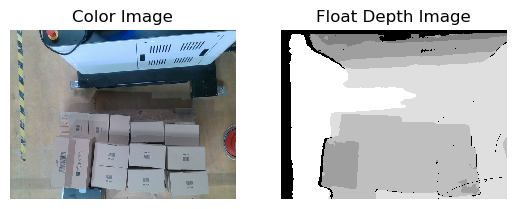

In [3]:
plt.subplot(121)
plt.imshow(cv.cvtColor(color_image, cv.COLOR_BGR2RGB))
plt.title('Color Image')
plt.axis('off')

plt.subplot(122)
plt.imshow(depth_display,'plasma')
plt.title('Float Depth Image')
plt.axis('off')
plt.show()



### Experiment with thresholding of the 3D Image

In [4]:
import cv2 as cv
import numpy as np

depth_image *= 1000  # now in mm


cv.namedWindow("Depth Threshold")
cv.createTrackbar("Min", "Depth Threshold", 0, 400, lambda x: None)
cv.createTrackbar("Max", "Depth Threshold", 100, 400, lambda x: None)

while True:
    min_val = cv.getTrackbarPos("Min", "Depth Threshold")
    max_val = cv.getTrackbarPos("Max", "Depth Threshold")

    mask = ((depth_image > min_val) & (depth_image < max_val)).astype(np.uint8) * 255
    cv.imshow("Depth Threshold", mask.astype(np.uint8))

    if cv.waitKey(1) & 0xFF == ord('q'):
        break

cv.destroyAllWindows()


In [ ]:
import open3d as o3d
import numpy as np

# Assuming you have intrinsics and depth_image (float32, in meters)
# Convert to Open3D depth image
depth_o3d = o3d.geometry.Image(depth_image)

# Camera intrinsics (replace with yours)
intrinsics = o3d.camera.PinholeCameraIntrinsic(
    width=depth_image.shape[1],
    height=depth_image.shape[0],
    fx=600, fy=600, cx=depth_image.shape[1]//2, cy=depth_image.shape[0]//2
)

# Create point cloud
pcd = o3d.geometry.PointCloud.create_from_depth_image(depth_o3d, intrinsics)

# Plane segmentation using RANSAC
plane_model, inliers = pcd.segment_plane(distance_threshold=0.01,
                                         ransac_n=3,
                                         num_iterations=1000)

print("Plane model:", plane_model)

# Create inlier mask
inlier_cloud = pcd.select_by_index(inliers)
non_floor_cloud = pcd.select_by_index(inliers, invert=True)

# Visualize or export point cloud without floor
o3d.visualization.draw_geometries([non_floor_cloud])
